In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import feature
from skimage import data, color, exposure
import caffe
%matplotlib inline

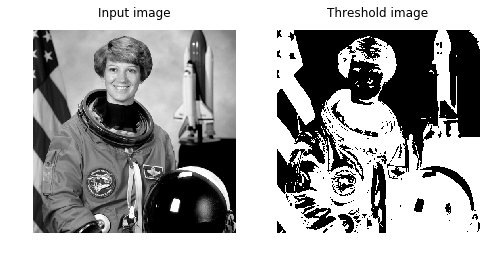

In [16]:
# original image
image = color.rgb2gray(data.astronaut())

# threshold image
mu = 0.5
imbw  = (image < mu);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(imbw, cmap=plt.cm.gray)
ax2.set_title('Threshold image')
ax1.set_adjustable('box-forced')
plt.show()


In [17]:
from caffe import layers as L
from caffe import params as P

def create_arq():
   
    n = caffe.NetSpec()
    n.data, n.label = L.Python( python_param = dict(module='caffelayerpython', layer='pydatagenerate'), ntop=2 )
    #n.data, n.label = L.Python( python_param = dict(module='caffelayerpython', layer='pydatagenerate', param_str='{im_shape=1}' ), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=1, stride=1, pad=1, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant',  value=0 ))  
    n.pool1 = L.Pooling(n.conv1, kernel_size=3, stride=1, pad=1, pool=P.Pooling.MAX)
    n.loss =  L.Python(n.pool1, n.label, python_param = dict(module = 'caffelayerpython', layer = 'pyimgloss'))    
    return 'name: "feactnet"\n' + str(n.to_proto())

with open('train.prototxt', 'w') as f:
    f.write(create_arq());

#print arq
print(create_arq())


name: "feactnet"
layer {
  name: "data"
  type: "Python"
  top: "data"
  top: "label"
  python_param {
    module: "caffelayerpython"
    layer: "pydatagenerate"
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 1
    pad: 1
    kernel_size: 3
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.00999999977648
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 1
    pad: 1
  }
}
layer {
  name: "loss"
  type: "Python"
  bottom: "pool1"
  bottom: "label"
  top: "loss"
  python_param {
    module: "caffelayerpython"
    layer: "pyimgloss"
  }
}



In [18]:

solvername = 'solver.prototxt';
train_prototxt_path = 'train.prototxt';
working_directory   = '.';

# solver
solver = {   
    'net': train_prototxt_path,
    'base_lr': 0.01,
    'lr_policy': 'inv',
    'gamma': 0.0001,
    'power': 0.75,
    'stepsize': 10,
    'display': 10,
    'max_iter': 100,
    'momentum': 0.95,
    'weight_decay': 0.0005,
    'snapshot': 1, # only at the end
    'snapshot_prefix': working_directory + '/snapshot',
    'solver_mode': 'CPU'
    };


# save
with open(solvername, 'w') as f:
    for key in solver.keys():
        value = solver[key];
        if type(value) is str and key != 'solver_mode':
            f.write('{} : "{}"\n'.format(key, value))
            print('{} : "{}"'.format(key, value))
        else: 
            f.write('{} : {}\n'.format(key, value))
            print('{} : {}'.format(key, value))


power : 0.75
max_iter : 100
stepsize : 10
base_lr : 0.01
weight_decay : 0.0005
lr_policy : "inv"
snapshot_prefix : "./snapshot"
snapshot : 1
gamma : 0.0001
solver_mode : CPU
net : "train.prototxt"
display : 10
momentum : 0.95


In [19]:
# CPU
caffe.set_mode_cpu()
# GPU
#caffe.set_device(0)
#caffe.set_mode_gpu()

In [20]:
# load net
net = caffe.Net(train_prototxt_path, caffe.TEST)

In [21]:
# net.blobs
# net.blobs['data'] 
# net.blobs['conv']

[(k, v.data.shape) for k, v in net.blobs.items()]


[('data', (10, 1, 256, 256)),
 ('label', (10, 1, 256, 256)),
 ('conv1', (10, 1, 256, 256)),
 ('pool1', (10, 1, 256, 256)),
 ('loss', (1,))]

In [22]:
# net.params
# net.params['conv'][0]
# net.params['conv'][1]

[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]


[('conv1', (1, 1, 3, 3), (1,))]

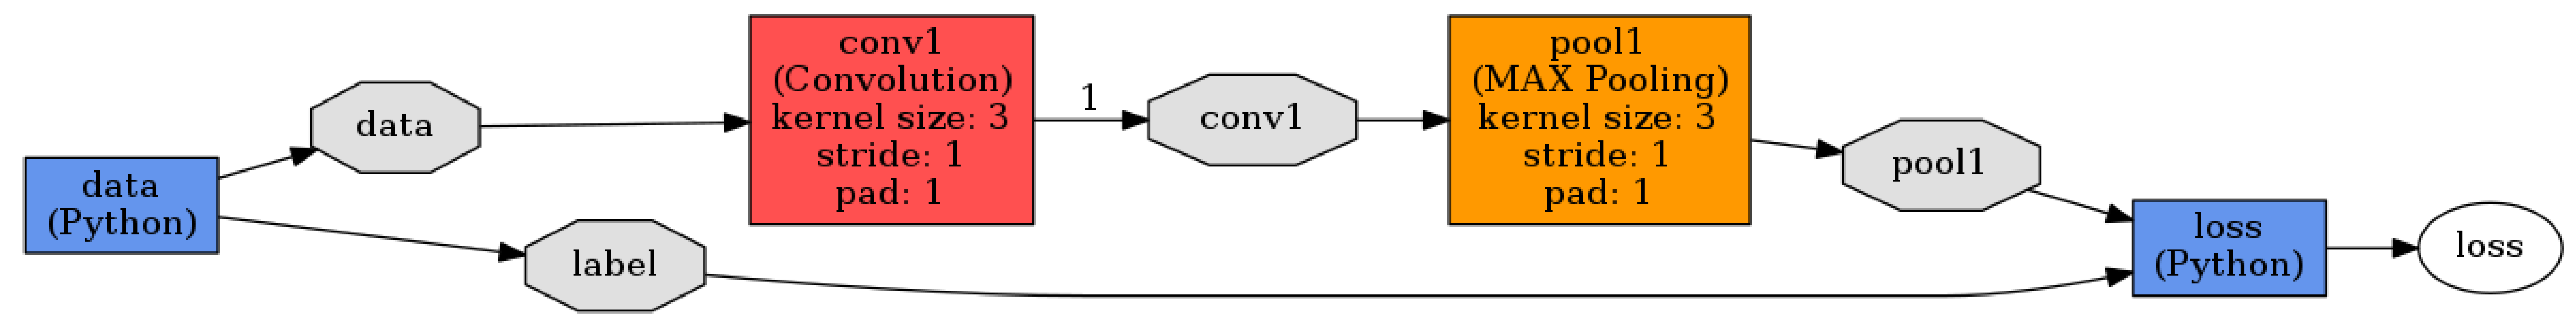

In [9]:
#import os
#os.system( 'python /opt/caffe/python/draw_net.py train.prototxt my_net.png' )
#open my_net.png

#prerequisitos
#pip install pydotplus
#apt-get update
#apt-get install graphviz

from google.protobuf import text_format
import caffe.draw
from caffe.proto import caffe_pb2

nnet = caffe_pb2.NetParameter();
text_format.Merge(open('train.prototxt').read(), nnet);
caffe.draw.draw_net_to_file(nnet, 'my_net.png', 'LR');

image_net = Image.open('my_net.png');
image_net.load();

fig = plt.figure(figsize=(100, 100))
plt.imshow(image_net);
plt.axis('off')
plt.show();

In [23]:
# forward
out = net.forward();
print(out['loss'])


[ 3.18525672]


In [24]:
#Training 
solver = caffe.SGDSolver('solver.prototxt');

#solver.net.forward()  # train net
#solver.test_nets[0].forward()  # test net (there can be more than one)
#solver.net.backward()
#solver.step(1)
#solver.solve()

solver.step(100)


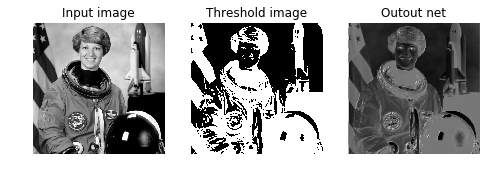

In [37]:
# test
# original image
net = caffe.Net('test.prototxt',caffe.TEST);

image = color.rgb2gray(data.astronaut());
#im = np.array(Image.open('cat_gray.jpg'));
im_input = image[np.newaxis, np.newaxis, :, :];
net.blobs['data'].reshape(*im_input.shape);
net.blobs['data'].data[...] = im_input;
out = net.forward();
imout = out['pool1'];

# threshold image
mu = 0.5;
imbw  = (image < mu);


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(imbw, cmap=plt.cm.gray)
ax2.set_title('Threshold image')
ax2.set_adjustable('box-forced')

ax3.axis('off')
ax3.imshow(imout[0,0,:,:], cmap=plt.cm.gray)
ax3.set_title('Outout net')
ax3.set_adjustable('box-forced')

plt.show()



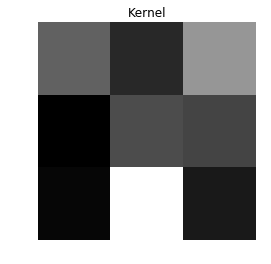

In [51]:
imk = net.params['conv1'][0].data[...];
plt.imshow(imk[0,0,:,:], cmap=plt.cm.gray);
plt.title('Kernel');
plt.axis('off');
plt.show();


In [ ]:
#accuracy = 0
#batch_size = solver.test_nets[0].blobs['data'].num
#test_iters = int(len(Xt) / batch_size)
#for i in range(test_iters):
#    solver.test_nets[0].forward()
#    accuracy += solver.test_nets[0].blobs['accuracy'].data
#accuracy /= test_iters

#print("Accuracy: {:.3f}".format(accuracy))
